# Problem Statement: 

## We need to develop a Recommender System with just TF-IDF Vectorisation Technique

### Using PySpark NLP pipeline

# Approach:

We begin by installing PySpark at the very beginning because Kaggle's current environment support doesn't have PySpark available by default for use.

In [1]:
!pip install pyspark

     |████████████████████████████████| 281.4 MB 34 kB/s              
  Preparing metadata (setup.py) ... - \ done
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=f40b1fe20b7371a22ccd3435fee74a28845a193a317d93a6a15d4a38ba3ec90b
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


We move ahead and initialise the PySpark session now.

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import pyspark # only run after findspark.init()
from pyspark.sql import SparkSession
# May take awhile locally
spark = SparkSession.builder.appName("Pyspark_4_NLP").getOrCreate()

cores = spark._jsc.sc().getExecutorMemoryStatus().keySet().size()
print("You are working with", cores, "core(s)")
spark

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/31 11:21:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


You are working with 1 core(s)


All good! We want to start by importing the relevant libraries now.

In [3]:
from pyspark.ml.feature import * #CountVectorizer,StringIndexer, RegexTokenizer,StopWordsRemover
from pyspark.sql.functions import * #col, udf,regexp_replace,isnull
from pyspark.sql.types import * #StringType,IntegerType
from pyspark.ml.classification import *
from pyspark.ml.evaluation import *
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# For pipeline development
from pyspark.ml import Pipeline 

Data sample view is coming up next.

In [4]:
raw_data = pd.read_csv('/kaggle/input/netflix-shows/netflix_titles.csv')

# Exploration and Basic Data Analysis

In [5]:
raw_data.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [6]:
raw_data.shape

(8807, 12)

In [7]:
# not going too far back in time, filtering out movies before 2000
raw_data = raw_data.query("release_year>1999")

# duplicate data check
raw_data.drop(['show_id'], axis  = 1).duplicated().sum()

0

In [8]:
raw_data.nunique()

show_id         8282
type               2
title           8282
director        4274
cast            7199
country          724
date_added      1754
release_year      22
rating            17
duration         206
listed_in        468
description     8252
dtype: int64

In [9]:
raw_data.isnull().sum()

show_id            0
type               0
title              0
director        2582
cast             807
country          808
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

### I feel that it would be suitable to concatenate title and description and build all the NLP pipeline on the concatenated result

In [10]:
raw_data['input_text'] = raw_data.title+' ' +raw_data.description
raw_data['input_text'] = raw_data['input_text'].str.lower()

https://stackoverflow.com/questions/31259891/put-customized-functions-in-sklearn-pipeline?msclkid=6b48bdf9a5e511ec8688e89b6b52b4c8

# Data Story:

Netflix has 8282 unique Movies and TV shows (figure 1) which have never failed to capture the attention of its content consumers who are spread across the globe.
Even though the entire entertainment industry has felt an evident rise in the love for short TV shows, we can still see the Movie category holding strong still being ~3 times more in number than its competition. (figure 2)



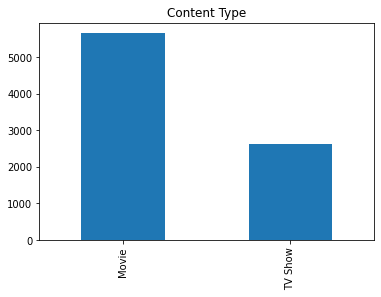

In [11]:
_ = raw_data.type.value_counts().plot(kind = 'bar', title = 'Content Type')

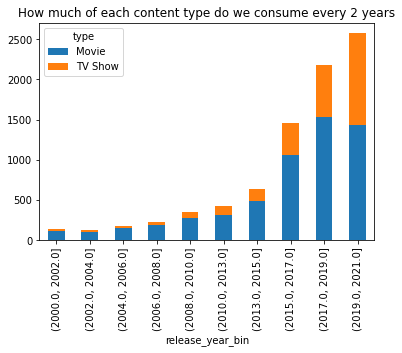

In [12]:
raw_data['release_year_bin'] = pd.cut(raw_data.release_year.astype(int), bins = 10, precision= 0)
_ = raw_data.pivot_table(index = 'release_year_bin', columns= 'type', aggfunc='count', values = 'show_id').plot(kind = 'bar',
                                                                                                           stacked = True,
                                                                                                           title = 'How much of each content type do we consume every 2 years')

<AxesSubplot:title={'center':'All-Time Popular Netflix Ratings'}>

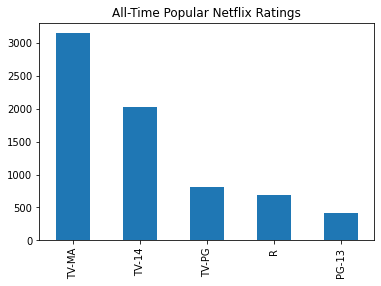

In [13]:
raw_data.rating.value_counts().head().plot(kind = 'bar', title = 'All-Time Popular Netflix Ratings')

### This was a basic story that was built from the first few visualisations. In a similar manner more stories can be found and shared with the readers. Now back to our desired system.

# PySpark NLP

# 1. Loading Data in the PySpark

In [14]:
# dropping release_year_bin column as pyspark doesn't support Interval class by default
# and throws the error -> TypeError: not supported type: <class 'pandas._libs.interval.Interval'>
# It would be useful to find a way around if we needed this feature but for the current usecase
# we do not need it and will move forward without this feature.

from pyspark.sql.types import *

## schema could be used to help pyspark pick the correct datatype but for now 
## I'll be using only two columns relevant for the whole pipeline

# schema = StructType([StructField("cast", StringType(), True)\
#   ,StructField("director", StringType(), True)\
#   ,StructField("title", StringType(), True)
#   ,StructField("show_id", StringType(), True)
#   ,StructField("country", StringType(), True)  
#   ,StructField("rating", StringType(), True)
#   ,StructField("listed_in", StringType(), True)
#   ,StructField("description", StringType(), True) 
#   ,StructField("input_text", StringType(), True)                   ])
raw_spark_data = spark.createDataFrame(raw_data[['show_id', 'input_text']])

# 2. Building NLP Pipeline with PySpark

I have decided to go with both TFIDF and Count Vector technique from the Bag of Words after having heard from many NLP practitioners that count vectors perform better than TF-IDF many times.

### So the approach would be to use the same regex and stop word remover for both pipelines but then going forward the final feature creating segments of the pipelines would differ.

In [15]:
from pyspark.ml.feature import *
from pyspark.ml import Pipeline



# split sentences into list of words

tokenize = RegexTokenizer(
  inputCol="input_text", 
  outputCol="regex_tokenizer_words", 
  pattern="[^a-z]"
)

# removing common stopwords from english vocabulary
remover = StopWordsRemover(
  inputCol="regex_tokenizer_words", 
  outputCol="filtered_words"
)


count_vectorizor_tf_version = HashingTF(
    inputCol="filtered_words", 
    outputCol="tfidf_count_vector", 
    numFeatures=50)

# TF-IDF
tf_idf_vectorizor = IDF(
    inputCol="tfidf_count_vector", 
    outputCol="features_tfidf")

# create a pipeline with the above stages
pipeline_tfidf = Pipeline(
  stages=[
    tokenize, 
    remover, 
    count_vectorizor_tf_version,
    tf_idf_vectorizor  
  ]
)




count_vectorizor_standalone_version = HashingTF(
    inputCol="filtered_words", 
    outputCol="features_count", 
    numFeatures=50)




# creating another pipeline with just count vectors
pipeline_count = Pipeline(
  stages=[
    count_vectorizor_standalone_version, 
  ]
)

# 3. Executing PySpark NLP Pipelines

In [16]:
# TFIDF pipeline
pipeline_tfidf_fit = pipeline_tfidf.fit(raw_spark_data)
feature_tfidf_df = pipeline_tfidf_fit.transform(raw_spark_data)

# Count Vector pipeline
pipeline_count_fit = pipeline_count.fit(feature_tfidf_df)
feature_count_tfidf_df = pipeline_count_fit.transform(feature_tfidf_df)

In [17]:
feature_tfidf_df.limit(5).toPandas().head()

,show_id,input_text,regex_tokenizer_words,filtered_words,tfidf_count_vector,features_tfidf
0,s1,dick johnson is dead as her father nears the e...,"[dick, johnson, is, dead, as, her, father, nea...","[dick, johnson, dead, father, nears, end, life...","(1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.3081758839995092, 1.4165681357833297, 1.152..."
1,s2,"blood & water after crossing paths at a party,...","[blood, water, after, crossing, paths, at, a, ...","[blood, water, crossing, paths, party, cape, t...","(0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","(0.0, 0.0, 1.1529411240992409, 1.2580892127780..."
2,s3,ganglands to protect his family from a powerfu...,"[ganglands, to, protect, his, family, from, a,...","[ganglands, protect, family, powerful, drug, l...","(0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.258089212778042, 1.319404387..."
3,s4,"jailbirds new orleans feuds, flirtations and t...","[jailbirds, new, orleans, feuds, flirtations, ...","[jailbirds, new, orleans, feuds, flirtations, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(0.0, 1.4165681357833297, 0.0, 0.0, 0.0, 1.321..."
4,s5,kota factory in a city of coaching centers kno...,"[kota, factory, in, a, city, of, coaching, cen...","[kota, factory, city, coaching, centers, known...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [18]:
feature_count_tfidf_df.limit(5).toPandas().head()

,show_id,input_text,regex_tokenizer_words,filtered_words,tfidf_count_vector,features_tfidf,features_count
0,s1,dick johnson is dead as her father nears the e...,"[dick, johnson, is, dead, as, her, father, nea...","[dick, johnson, dead, father, nears, end, life...","(1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.3081758839995092, 1.4165681357833297, 1.152...","(1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,s2,"blood & water after crossing paths at a party,...","[blood, water, after, crossing, paths, at, a, ...","[blood, water, crossing, paths, party, cape, t...","(0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","(0.0, 0.0, 1.1529411240992409, 1.2580892127780...","(0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
2,s3,ganglands to protect his family from a powerfu...,"[ganglands, to, protect, his, family, from, a,...","[ganglands, protect, family, powerful, drug, l...","(0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.258089212778042, 1.319404387...","(0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
3,s4,"jailbirds new orleans feuds, flirtations and t...","[jailbirds, new, orleans, feuds, flirtations, ...","[jailbirds, new, orleans, feuds, flirtations, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(0.0, 1.4165681357833297, 0.0, 0.0, 0.0, 1.321...","(0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
4,s5,kota factory in a city of coaching centers kno...,"[kota, factory, in, a, city, of, coaching, cen...","[kota, factory, city, coaching, centers, known...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


# 4. Format Conversion for Calculations

PySpark returns the features in the form of array of SparseVectors which need to be converted to SparseMatrix format supported by Scipy which is the library that Numpy builds upon.

We want to have the SparseMatrix format in order for the sklearn similarity function to be able to calculate similarity on the vectors.

First we want to convert the SparseVectors to plain array of list.

In [19]:
import pyspark.sql.functions as F


## internally vector_to_array function does the below steps
# to_array = F.udf(lambda v: v.toArray().tolist(), T.ArrayType(T.FloatType()))
# feature_df = feature_df.withColumn('array_features', to_array('features'))

from pyspark.ml.functions import vector_to_array
feature_count_tfidf_df = feature_count_tfidf_df.withColumn('array_features_tfidf', vector_to_array('features_tfidf'))\
                                    .withColumn('array_features_count', vector_to_array('features_count'))


In [20]:
feature_count_tfidf_df.toPandas().head()

,show_id,input_text,regex_tokenizer_words,filtered_words,tfidf_count_vector,features_tfidf,features_count,array_features_tfidf,array_features_count
0,s1,dick johnson is dead as her father nears the e...,"[dick, johnson, is, dead, as, her, father, nea...","[dick, johnson, dead, father, nears, end, life...","(1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.3081758839995092, 1.4165681357833297, 1.152...","(1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.3081758839995092, 1.4165681357833297, 1.152...","[1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,s2,"blood & water after crossing paths at a party,...","[blood, water, after, crossing, paths, at, a, ...","[blood, water, crossing, paths, party, cape, t...","(0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","(0.0, 0.0, 1.1529411240992409, 1.2580892127780...","(0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 1.1529411240992409, 1.2580892127780...","[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
2,s3,ganglands to protect his family from a powerfu...,"[ganglands, to, protect, his, family, from, a,...","[ganglands, protect, family, powerful, drug, l...","(0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.258089212778042, 1.319404387...","(0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.258089212778042, 1.319404387...","[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
3,s4,"jailbirds new orleans feuds, flirtations and t...","[jailbirds, new, orleans, feuds, flirtations, ...","[jailbirds, new, orleans, feuds, flirtations, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(0.0, 1.4165681357833297, 0.0, 0.0, 0.0, 1.321...","(0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.0, 1.4165681357833297, 0.0, 0.0, 0.0, 1.321...","[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
4,s5,kota factory in a city of coaching centers kno...,"[kota, factory, in, a, city, of, coaching, cen...","[kota, factory, city, coaching, centers, known...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [21]:
feature_count_tfidf_df_pandas = feature_count_tfidf_df.toPandas()

In [22]:
feature_count_tfidf_df_pandas['features_count'].values[:2]

array([SparseVector(50, {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 19: 1.0, 25: 1.0, 27: 1.0, 28: 1.0, 29: 1.0, 30: 2.0, 34: 1.0, 38: 1.0, 41: 1.0, 43: 1.0, 45: 1.0, 47: 1.0, 48: 1.0}),
       SparseVector(50, {2: 1.0, 3: 1.0, 6: 1.0, 9: 1.0, 14: 1.0, 15: 1.0, 20: 1.0, 21: 1.0, 23: 1.0, 26: 1.0, 29: 2.0, 36: 1.0, 39: 1.0, 41: 1.0, 42: 1.0, 47: 1.0, 49: 1.0})],
      dtype=object)

In [23]:
feature_count_tfidf_df_pandas['array_features_count'].values[:2]

array([list([1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0]),
       list([0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0])],
      dtype=object)

The array of list would finally be converted to Compressed Sparse Row matrix which is suitable for the similarity calculation method offered by sklearn package.

> scipy.sparse.csr_matrix(list(feature_df_pandas['array_features'].values))

The above snippet of code takes care of the final conversion.

Here I have calculated the similarity for the entire corpus with itself simply to demonstrate the use of cosine_similarity method. It works fast on sparse matrices for our scale of data.

In [24]:
import scipy
from sklearn.metrics.pairwise import cosine_similarity

similarity = cosine_similarity(scipy.sparse.csr_matrix(list(feature_count_tfidf_df_pandas['array_features_tfidf'].values)), scipy.sparse.csr_matrix(list(feature_count_tfidf_df_pandas['array_features_tfidf'].values)))

In [25]:
similarity.shape

(8282, 8282)

# 5. Preparing for Prediction for New Entries

The function 'new_entry_prediction()' has been designed to take a search text, the number of similarity results one would like to see, both the pipelines for tfidf and count vector, the corpus with the prepared main features and a flag to prompt whether tfidf model is to be used for similarity calculation or count vector model.

Now we'll get to see what kind of recommendations our designed engine is making given a few categories of content like war, comedy, romance etc.

So for each text input we'll have two similarity results, one from TFIDF and the other from Count Vector

In [26]:
def new_entry_prediction(search_text, top_n_results, pipeline_fitted_tfidf, 
                         pipeline_fitted_count, prepared_feature_corpus, tfidf_flag = True):
    #import math
    
    if tfidf_flag:
        feature_array_col = 'array_features_tfidf'
    else:
        feature_array_col = 'array_features_count'
        
    pred_raw_data = pd.DataFrame(data = {"input_text":[search_text]})
    pred_raw_data['input_text'] = pred_raw_data['input_text'].str.lower()
    
    test_input = spark.createDataFrame(pred_raw_data)
    
    #pred_feature_df = pipeline_fitted.transform(test_input)
    feature_tfidf_df = pipeline_tfidf_fit.transform(test_input)
    pred_feature_df = pipeline_fitted_count.transform(feature_tfidf_df)
    
    pred_feature_df = pred_feature_df.withColumn('array_features_tfidf', vector_to_array('features_tfidf'))\
                                    .withColumn('array_features_count', vector_to_array('features_count'))
    
    pred_feature_df_pandas = pred_feature_df.toPandas()
    #print(pred_feature_df_pandas.columns)
    
    pred_similarity = cosine_similarity( scipy.sparse.csr_matrix(list(prepared_feature_corpus[feature_array_col].values)),
                                        scipy.sparse.csr_matrix(list(pred_feature_df_pandas[feature_array_col].values)))
    
    prepared_feature_corpus['predicted_similarity'] = pred_similarity
    
    top_n_df = None
    shape_corpus = prepared_feature_corpus.shape[0]
    if top_n_results > 0 and top_n_results<=shape_corpus:
        top_n_df = prepared_feature_corpus.sort_values(['predicted_similarity'], ascending = False).head(top_n_results)
    
    else:
        print("Kindly put a value between 1 and {0}".format(shape_corpus))
    
    if top_n_df is not None:
        print("Recommendations: \n")
        print_df = top_n_df[['input_text', 'predicted_similarity']]
        #print(top_n_df[['input_text', 'predicted_similarity']])
        for i in range(0, top_n_df.shape[0]):
            print(str(i+1)+ '.')
            print(print_df.iloc[i].input_text)
            print('----> with a Similarity Score: '+str(print_df.iloc[i].predicted_similarity)+ '<---- \n')
        
    return top_n_df

# 6. Prediction Cases, Observations and Analysis

# Action Content 

In [27]:
search_text = 'action fight crime fighting scenes punching guns mafia'
top_n_results = 5
pipeline_fitted_tfidf = pipeline_tfidf_fit
pipeline_fitted_count = pipeline_count_fit
prepared_feature_corpus = feature_count_tfidf_df_pandas
top_n_df = new_entry_prediction(search_text, top_n_results, pipeline_fitted_tfidf, 
                                pipeline_fitted_count, prepared_feature_corpus, tfidf_flag = True)

Recommendations: 

1.
the angry birds movie 2 enemies turn into frenemies when the pigs call for a truce with the birds to unite against a formidable new foe that’s threatening all of their homes.
----> with a Similarity Score: 0.6992710609628546<---- 

2.
anger management after a gentle businessman is forced to get anger management counseling, his therapist moves in – but turns out to have anger issues of his own.
----> with a Similarity Score: 0.6590344380433819<---- 

3.
memory love losing her memory – and her boyfriend – after a car accident, jia-en crosses paths with a heart transplant recipient who helps her recall her past.
----> with a Similarity Score: 0.6511586646883918<---- 

4.
the writer when accused of a murder eerily parallel to a plot in his novel, a best-selling crime writer must navigate a web of hidden enemies.
----> with a Similarity Score: 0.6272922007712964<---- 

5.
power rangers samurai a new generation of power rangers must master the symbols of samurai power, 

In [28]:
search_text = 'action fight crime fighting scenes punching guns mafia'
top_n_results = 5
pipeline_fitted_tfidf = pipeline_tfidf_fit
pipeline_fitted_count = pipeline_count_fit
prepared_feature_corpus = feature_count_tfidf_df_pandas
top_n_df = new_entry_prediction(search_text, top_n_results, pipeline_fitted_tfidf, 
                                pipeline_fitted_count, prepared_feature_corpus, tfidf_flag = False)

Recommendations: 

1.
the angry birds movie 2 enemies turn into frenemies when the pigs call for a truce with the birds to unite against a formidable new foe that’s threatening all of their homes.
----> with a Similarity Score: 0.6741998624632419<---- 

2.
anger management after a gentle businessman is forced to get anger management counseling, his therapist moves in – but turns out to have anger issues of his own.
----> with a Similarity Score: 0.6454972243679029<---- 

3.
memory love losing her memory – and her boyfriend – after a car accident, jia-en crosses paths with a heart transplant recipient who helps her recall her past.
----> with a Similarity Score: 0.632455532033676<---- 

4.
between two ferns: the movie armed with awkward questions and zero self-awareness, zach galifianakis hits the road to find famous interview subjects for his no-budget talk show.
----> with a Similarity Score: 0.6201736729460423<---- 

5.
the writer when accused of a murder eerily parallel to a plot in

# Analysis

#### This seems to be fine but I believe that the 4th document in TFIDF should have been at the top as it covers the keywords more intensely. Notice how the word 'crime' is present in both query and 4th result but still it gets the 4th rank.

#### Also its funny how 'between two ferns' seems to have ended up 4th on Count Vector's list because it had the word 'armed' even though it has nothing to do with the context of violence here. And that my friends is how Bag of Words algorithms fail to capture the context of words.

#### It means that the words would be deemed same in BoW algorithms as it doesn't consider the context or the surrounding words when making its vectors
* 'dog toy' - a toy for the dog to play with 
* 'toy dog' - a dummy of a dog/soft toy perhaps to play with

#### It may seem initially like TFIDF did better here because of the 'between the ferns' mistake made by CountVector but it did also miss the word 'crime' which would be so basic for any recommendation to be made. We can see that it is a property of Count Vectors to have a benefit when two texts that are being compared share same keywords.

# Romantic Comedy Content

In [29]:
search_text = 'Romantic comedy'
top_n_results = 5
pipeline_fitted_tfidf = pipeline_tfidf_fit
pipeline_fitted_count = pipeline_count_fit
prepared_feature_corpus = feature_count_tfidf_df_pandas
top_n_df = new_entry_prediction(search_text, top_n_results, pipeline_fitted_tfidf, 
                                pipeline_fitted_count, prepared_feature_corpus, tfidf_flag = True)

Recommendations: 

1.
just you when her uptight new boss and landlord starts a war on office romances, plucky liang-liang quickly starts looking for ways to get him to lighten up.
----> with a Similarity Score: 0.7728968532290629<---- 

2.
hazel brugger: tropical in this stand-up special, comedian hazel brugger offers her breezy takes on unruly geese, chatty gynecologists, german bank loans and more.
----> with a Similarity Score: 0.7537225315637165<---- 

3.
first kiss a starry-eyed employee of a hot cosmetics company hires a dreamy photographer who is secretly indebted to a major rival – her sketchy aunt.
----> with a Similarity Score: 0.7019579203744745<---- 

4.
transformers: rescue bots follow the adventure of four young transformers, heatwave, chase, blades and boulder, and their human counterparts: a family of emergency responders.
----> with a Similarity Score: 0.6728275920143738<---- 

5.
queens of comedy eight women perform in front of celebrity judges and compete for the tit

In [30]:
search_text = 'Romantic comedy'
top_n_results = 5
pipeline_fitted_tfidf = pipeline_tfidf_fit
pipeline_fitted_count = pipeline_count_fit
prepared_feature_corpus = feature_count_tfidf_df_pandas
top_n_df = new_entry_prediction(search_text, top_n_results, pipeline_fitted_tfidf, 
                                pipeline_fitted_count, prepared_feature_corpus, tfidf_flag = False)

Recommendations: 

1.
just you when her uptight new boss and landlord starts a war on office romances, plucky liang-liang quickly starts looking for ways to get him to lighten up.
----> with a Similarity Score: 0.7620007620011431<---- 

2.
hazel brugger: tropical in this stand-up special, comedian hazel brugger offers her breezy takes on unruly geese, chatty gynecologists, german bank loans and more.
----> with a Similarity Score: 0.7276068751089988<---- 

3.
first kiss a starry-eyed employee of a hot cosmetics company hires a dreamy photographer who is secretly indebted to a major rival – her sketchy aunt.
----> with a Similarity Score: 0.6804138174397716<---- 

4.
queens of comedy eight women perform in front of celebrity judges and compete for the title of india’s top female stand-up comedian.
----> with a Similarity Score: 0.6488856845230501<---- 

5.
transformers: rescue bots follow the adventure of four young transformers, heatwave, chase, blades and boulder, and their human coun

# Analysis

#### This is something peculiar, though I am satisfied with the results in this search outcome from both models, I have a strong feeling that Count Vector did a bit of a better job here as it put queens of comedy above transformers which by the way I am not sure why it even ended up in top 5 perhaps because it has the word 'family' in it?

# War Content

In [31]:
search_text = 'the war of the legends'
top_n_results = 5
pipeline_fitted_tfidf = pipeline_tfidf_fit
pipeline_fitted_count = pipeline_count_fit
prepared_feature_corpus = feature_count_tfidf_df_pandas
top_n_df = new_entry_prediction(search_text, top_n_results, pipeline_fitted_tfidf, 
                                pipeline_fitted_count, prepared_feature_corpus, tfidf_flag = True)

Recommendations: 

1.
shot! the psycho-spiritual mantra of rock aptly named iconic rock photographer mick rock reconstructs his journey through the thrilling and murky universe of rock 'n' roll history.
----> with a Similarity Score: 0.7382833080112235<---- 

2.
pegasus after a five-year suspension, a once-legendary race car driver decides to get back in the game against a new generation of opponents.
----> with a Similarity Score: 0.722263662892445<---- 

3.
sintonia three teens living in the same são paulo favela pursue their dreams while maintaining their friendship, amid a world of music, drugs and religion.
----> with a Similarity Score: 0.6776035224005892<---- 

4.
chris rock: tamborine chris rock takes the stage in brooklyn for a comedy special filled with searing observations on fatherhood, infidelity and american politics.
----> with a Similarity Score: 0.6523197256447757<---- 

5.
operation red sea a special task force takes on a risky operation to evacuate civilians amid civ

In [32]:
search_text = 'the war of the legends'
top_n_results = 5
pipeline_fitted_tfidf = pipeline_tfidf_fit
pipeline_fitted_count = pipeline_count_fit
prepared_feature_corpus = feature_count_tfidf_df_pandas
top_n_df = new_entry_prediction(search_text, top_n_results, pipeline_fitted_tfidf, 
                                pipeline_fitted_count, prepared_feature_corpus, tfidf_flag = False)

Recommendations: 

1.
pegasus after a five-year suspension, a once-legendary race car driver decides to get back in the game against a new generation of opponents.
----> with a Similarity Score: 0.7372097807744857<---- 

2.
shot! the psycho-spiritual mantra of rock aptly named iconic rock photographer mick rock reconstructs his journey through the thrilling and murky universe of rock 'n' roll history.
----> with a Similarity Score: 0.7071067811865475<---- 

3.
operation red sea a special task force takes on a risky operation to evacuate civilians amid civil war. based on the 2015 mission to rescue chinese citizens in yemen.
----> with a Similarity Score: 0.6882472016116853<---- 

4.
the sons of sam: a descent into darkness the son of sam case grew into a lifelong obsession for journalist maury terry, who became convinced that the murders were linked to a satanic cult.
----> with a Similarity Score: 0.6565321642986127<---- 

5.
chris rock: tamborine chris rock takes the stage in brookly

# Analysis

#### Count Vectors clearly did a much better job putting operation red sea on 3rd while TFIDF has Sintonia which I do not believe is a war movie going by its description. It also did a lovely job with The Sons of Sam on 4th position which has keywords like murder, satanic etc. going pretty well with the War theme.

#### Also I have an interesting theory why 'Shot!' ended up on top or top 2 for both, it might be because of the word 'legend' in the query and 'Shot!' also being themed around discussing history of music genre which definitely would land around 'legend' due to the use of the word 'legend' around history etc. 
#### I confirmed that by removing the word 'legend' from the query and running TFIDF model again for War theme below ['Shot!' nowhere to be found in the top 5] :) Let me know what you think!

In [33]:
search_text = 'the war of the'
top_n_results = 5
pipeline_fitted_tfidf = pipeline_tfidf_fit
pipeline_fitted_count = pipeline_count_fit
prepared_feature_corpus = feature_count_tfidf_df_pandas
top_n_df = new_entry_prediction(search_text, top_n_results, pipeline_fitted_tfidf, 
                                pipeline_fitted_count, prepared_feature_corpus, tfidf_flag = False)

Recommendations: 

1.
who's the one a doctor performs plastic surgery on a fat man who's been jilted, and continues his transformation by turning him into a handsome, desirable man.
----> with a Similarity Score: 0.8574929257125441<---- 

2.
ip man an occupying japanese general challenges chinese men to duels to prove the superiority of the japanese, but ip man refuses to fight – at first.
----> with a Similarity Score: 0.7142857142857143<---- 

3.
marc maron: end times fun marc maron wades through a swamp of vitamin hustlers, evangelicals and grown male nerd children, culminating in a gleefully filthy end-times fantasy.
----> with a Similarity Score: 0.6933752452815365<---- 

4.
wonho chung: live in new york at the comic strip's first arabic stand-up show, wonho chung ratchets up the laughs by tackling unique names, life in jordan, accents and more.
----> with a Similarity Score: 0.6405126152203485<---- 

5.
a mission in an old movie a young man struggles with his overbearing mother w

# Finance Content

In [34]:
search_text = 'wallstreet money cash'
top_n_results = 5
pipeline_fitted_tfidf = pipeline_tfidf_fit
pipeline_fitted_count = pipeline_count_fit
prepared_feature_corpus = feature_count_tfidf_df_pandas
top_n_df = new_entry_prediction(search_text, top_n_results, pipeline_fitted_tfidf, 
                                pipeline_fitted_count, prepared_feature_corpus, tfidf_flag = True)

Recommendations: 

1.
gelo a punjabi woman who works on a farm must endure the difficulties of living in an oppressive class-based society and a dysfunctional community.
----> with a Similarity Score: 0.8247156271241594<---- 

2.
dangerous roads using various 4x4 vehicles, celebrities steer their way across some of the most infamous roads and trickiest terrains on earth.
----> with a Similarity Score: 0.6771288238283468<---- 

3.
the smart money woman five glamorous millennials strive for success as they juggle careers, finances, love and friendships. based on arese ugwu's 2016 best-selling novel.
----> with a Similarity Score: 0.6709284624508404<---- 

4.
reframe theater experience with you perfume's reframe 2019 concert, performed to great effect in the newly reconstructed line cube shibuya, is recreated as a high-tech concert film.
----> with a Similarity Score: 0.6291624747492458<---- 

5.
mad money a woman joins the janitorial staff of the federal reserve bank and conspires with t

In [35]:
search_text = 'wallstreet money leonardo'
top_n_results = 5
pipeline_fitted_tfidf = pipeline_tfidf_fit
pipeline_fitted_count = pipeline_count_fit
prepared_feature_corpus = feature_count_tfidf_df_pandas
top_n_df = new_entry_prediction(search_text, top_n_results, pipeline_fitted_tfidf, 
                                pipeline_fitted_count, prepared_feature_corpus, tfidf_flag = False)

Recommendations: 

1.
secrets of scotland yard revisit famous cases and explore the history of scotland yard, one of the world's oldest detective forces and a name synonymous with crime solving.
----> with a Similarity Score: 0.643267520902677<---- 

2.
stray bullet in 1976 beirut, after a rendezvous with her old flame, soon-to-wed noha witnesses a violent incident and changes course on a path to self-realization.
----> with a Similarity Score: 0.629940788348712<---- 

3.
gelo a punjabi woman who works on a farm must endure the difficulties of living in an oppressive class-based society and a dysfunctional community.
----> with a Similarity Score: 0.6221710168382553<---- 

4.
the woman in the window confined to her home by agoraphobia, a psychologist becomes obsessed with her new neighbors — and solving a brutal crime she witnesses from her window.
----> with a Similarity Score: 0.6019292654288462<---- 

5.
she's gotta have it nola darling struggles to stay true to herself and her drea

# Analysis

#### None of the two models impress me in this case. However TFIDF got 'Smart Money' on the 3rd and 'Mad Money' on 5th rank (which actually perhaps should have been the 1st ranker) which Count Vector completely failed to capture while the word money is there in both the query and the TFIDF 5th ranker element. Here TFIDF definitely did a bit better.

#### This is quite the opposite of what happened in our first observation in the Action Content query. There TFIDF was failing to consider exact word matches and Count Vector was doing a great job of it and we had established that Count Vector was better at it.

#### Now that we have the opposite happening in this case we should restrain from establishing that Count Vectors is better than TFIDF on queries which have exact match with the documents

# 7. Conclusion

#### It seems like in this case neither TFIDF nor Count Vectors could do a really great job of making those near perfect recommendations that Netflix does. (Lol I know how Netflix algorithm is far more complicated compared to this one so please take it as a joke :P)

#### Its interesting that for most cases Count Vectors did a slightly better job than TFIDF even though TFIDF is supposed to be intelligent with handling frequent words. We had already removed stop words so TFIDF might have lost its advantage there too.

#### Additionally we couldn't establish anything about any of the algorithms being better when the query and the document being compared have the same keywords present in both of them.

# 8. Up Next

#### What if we combine the vectors we get from TFIDF and Count Vectors and try our luck with a single combined featureset for this data?